# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.decomposition import PCA
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
azdiascopy = azdias.copy()
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';',header=None)
new_header = feat_info.iloc[0]
feat_info = feat_info[1:] 
feat_info.columns = new_header

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
#feat_info.head()
print("azdias number of rows {} , number of columns {}".format(len(azdias.index) , len(azdias.columns)))
print("feat_info number of rows {} , number of columns {}".format(len(feat_info.index) , len(feat_info.columns)))

azdias number of rows 891221 , number of columns 85
feat_info number of rows 85 , number of columns 4


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
print('Number of  missing values before cleaning is {}'.format(azdias.isnull().sum().sum()))

for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
print('Total number of missing values after conversion is {}'.format(azdias.isnull().sum().sum()))


Number of  missing values before cleaning is 4896838
Total number of missing values after conversion is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_per_column =(azdias.isnull().sum()/len(azdias))*100

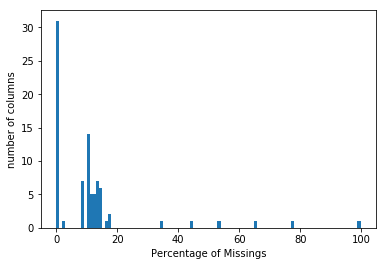

In [6]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_per_column, bins=100)
plt.ylabel('number of columns')
plt.xlabel('Percentage of Missings')
plt.show()

In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
more_than_20_percent_columns = missing_per_column[missing_per_column>20]
more20 = more_than_20_percent_columns.index.tolist()
for i in range(len(more20)):
    azdias.drop(more20[i], axis=1, inplace=True)
    
print(more20)    
print("azdias number of rows after Nan column cleaning {} , number of columns {}".format(len(azdias.index) , len(azdias.columns)))


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
azdias number of rows after Nan column cleaning 891221 , number of columns 79


In [8]:
print("azdias number of rows after Nan column cleaning {} , number of columns {}".format(len(azdias.index) , len(azdias.columns)))


#### Discussion 1.1.2: Assess Missing Data in Each Column

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'] this list has the columns to be deleted since they have more than 20 percent missing of data

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [9]:
# How much data is missing in each row of the dataset?
missing_per_row = (azdias.isnull().sum(axis=1)/len(azdias.columns))*100

In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

cut_off = 20 
number_rows_missing_more_than_20 = missing_per_row[missing_per_row > cut_off].count()                               
number_rows_missing_less_than_20 = missing_per_row[missing_per_row < cut_off].count()
print("number of rows missing more than 20% of the data is {} , while number of rows missing less than 20% {}".format(number_rows_missing_more_than_20 , number_rows_missing_less_than_20))

rows_missing_more_than_20 = missing_per_row[missing_per_row > cut_off]
ind_rmmt20l = rows_missing_more_than_20.index.tolist() # should be deleted
rows_missing_less_than_20 = missing_per_row[missing_per_row < cut_off]
ind_rmlt20l = rows_missing_less_than_20.index.tolist()
azdias_more_20 = azdias.drop(azdias.index[ind_rmmt20l])
azdias_less_20 = azdias.drop(azdias.index[ind_rmlt20l])

number of rows missing more than 20% of the data is 98934 , while number of rows missing less than 20% 792287


In [11]:
print("this is azdias with only rows that has less than 20 percent missing")
azdias_more_20 # this is the one less informative (has more missings in their row)

In [12]:
print("this is azdias with only rows that has more than 20 percent missing")
azdias_less_20.head() # this is the one that is more informative 

In [13]:
uniq_ = [] # list of uniq values in each coluymn to bes tested 
count_ = [] # Count of each unique value to be tested 
uniq_2 = [] # same for azdiac - azdias < 20 rows Naan dropped
count_2 = [] # same for azdiac - azdias < 20 rows Naan dropped
columns_to_test = [] # 5 columns to be tested 

for i in range(5):
    unique_values, counts = np.unique(azdias_more_20.iloc[:, i],return_counts=True)
    uniq_.append(unique_values)
    count_.append(counts)
    unique_values2, counts2 = np.unique(azdias_less_20.iloc[:, i],return_counts=True)
    uniq_2.append(unique_values2)
    count_2.append(counts2)
    columns_to_test.append(azdias_less_20.columns[i])


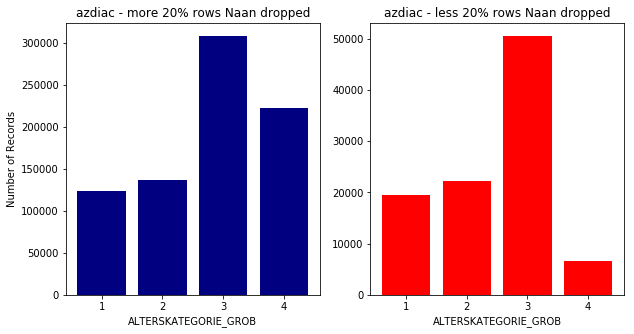

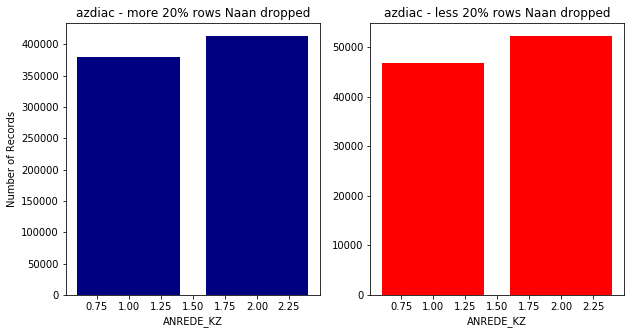

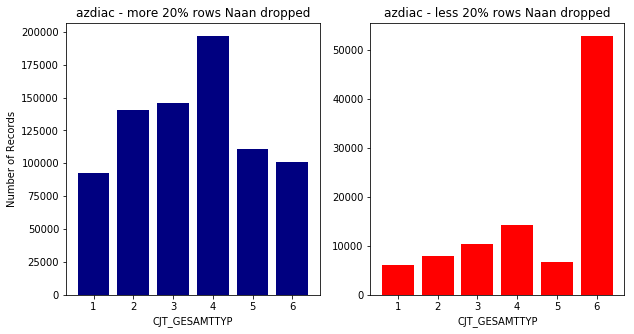

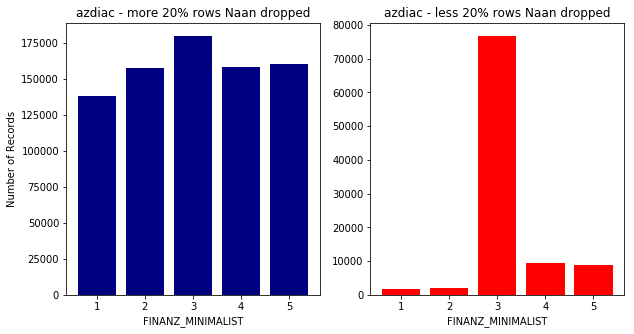

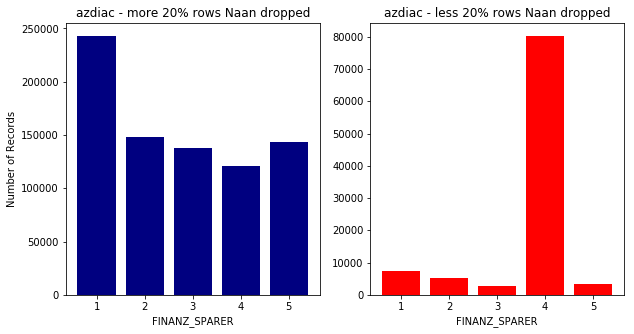

In [14]:
for j in range(5):
    for i in range(1):
        fig = plt.figure(figsize=(10,5))
        
        plt.subplot(i+1, 2, 1)
        plt.bar(uniq_[j], count_[j], color='navy') 
        plt.title('azdiac - more 20% rows Naan dropped')
        plt.xlabel(str(columns_to_test[j]))
        plt.ylabel('Number of Records')
        ###################################################################
        plt.subplot(i+1, 2, 2)
        plt.bar(uniq_2[j], count_2[j], color='red') 
        plt.title('azdiac - less 20% rows Naan dropped')
        plt.xlabel(str(columns_to_test[j]))
        


#### Discussion 1.1.3: Assess Missing Data in Each Row

for the tested 5 columns , we can see that the one on the blue represents the dataset when rows that have missing values more than 20 delete while the red when the opposite. we can see that the blue one has more information. For example in FINANZ_SPARER there are far more records for each unique value 1,2,3,4,5  

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [15]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
ordinal_columns = [] ;  binary_categorical_columns = [] ;multi_level_categorical_columns = [] ; numeric_columns = [] ; mixed_columns = [] ; interval_columns = [];

In [16]:
# remove rows from feat_info that has the attribute (column name) which is NAN > 20 
feat_info_more_20 = feat_info.copy()
mask = feat_info_more_20['attribute'].isin(more20)
feat_info_more_20 = feat_info_more_20[~mask]
feat_info_more_20.reset_index(inplace = True , drop=True)
feat_info_more_20.head()

,attribute,information_level,type,missing_or_unknown
0,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
1,ANREDE_KZ,person,categorical,"[-1,0]"
2,CJT_GESAMTTYP,person,categorical,[0]
3,FINANZ_MINIMALIST,person,ordinal,[-1]
4,FINANZ_SPARER,person,ordinal,[-1]


In [17]:
# GET the columns for each type 
ind_cat = feat_info_more_20[feat_info_more_20['type'] == "categorical"].index.tolist()
cat_colunm_names = azdias_more_20.columns[ind_cat]
ind_ord = feat_info_more_20[feat_info_more_20['type'] == "ordinal"].index.tolist()
ind_num = feat_info_more_20[feat_info_more_20['type'] == "numeric"].index.tolist()
ind_mix= feat_info_more_20[feat_info_more_20['type'] == "mixed"].index.tolist()
mix_colunm_names = azdias_more_20.columns[ind_mix]
ind_int= feat_info_more_20[feat_info_more_20['type'] == "interval"].index.tolist()


In [18]:
cat_colunm_names = azdias_more_20.columns[ind_cat]
cat_bin = {}
cat_multi = {}
for i , column in enumerate(cat_colunm_names): 
    if azdias_more_20.loc[:,cat_colunm_names[i]].nunique() == 2: 
        cat_bin[cat_colunm_names[i]] = azdias_more_20.loc[:,cat_colunm_names[i]].nunique() 
    else: 
        cat_multi[cat_colunm_names[i]] = azdias_more_20.loc[:,cat_colunm_names[i]].nunique()

def merge_two_dicts(x, y):
    z = x.copy()    
    z.update(y)    
    return z
cat_d = merge_two_dicts(cat_bin, cat_multi)



In [19]:
cat_multi_colunm_names = list(cat_multi.keys())
cat_bin_colunm_names = list(cat_bin.keys())

In [20]:
#################################Categorical#########################################

In [21]:
# Categorical. Binary
# if biary and string convert to numbers 
# here OST_WEST_KZ  w => 0 , O -> 1
for i in range(len(cat_bin_colunm_names)):
    if type(azdias_more_20.loc[:, cat_bin_colunm_names[i]].unique()[0]) == str: 
        # if the categorical column is bima
        l = azdias_more_20.loc[:, cat_bin_colunm_names[i]].unique()
        azdias_more_20[cat_bin_colunm_names[i]].replace({l[0]: 0, l[1]: 1}, inplace=True) 

In [22]:
#azdias_more_20.drop(columns='CAMEO_DEU_2015' , inplace=True)
#cat_d.pop('CAMEO_DEU_2015') ; cat_multi.pop('CAMEO_DEU_2015') ; cat_multi_colunm_names.remove("CAMEO_DEU_2015")

In [23]:
cat_multi_colunm_names.remove('GEBAEUDETYP')
cat_multi_colunm_names.remove('CAMEO_DEU_2015')

In [24]:
azdias_more_20.drop(['GEBAEUDETYP' , 'CAMEO_DEU_2015'], inplace= True , axis=1)

In [25]:
# delete CAMEO_DEU_2015 because it has so many categorires 
# delete GEBAEUDETYP becaise it has more unique values than the ones in the Udacity customer dataset
#cat_d.pop('CAMEO_DEU_2015') ; cat_multi.pop('CAMEO_DEU_2015') ; cat_multi_colunm_names.remove("CAMEO_DEU_2015")

In [26]:
# Categorical. Multi -> get_dummies
# X is a new dataframe that has the dummied columns 
X = azdias_more_20[cat_multi_colunm_names]
azdias_more_20_multi_dum = pd.get_dummies(X , columns=X.columns , drop_first=True)

In [27]:
# here we drop all cat columns since we dummied them in azdias_more_20_multi_dum
azdias_more_20_no_multi_cat = azdias_more_20.drop(cat_multi_colunm_names, axis = 1)

In [28]:
# combine both
azdias_cat = pd.concat([azdias_more_20_multi_dum, azdias_more_20_no_multi_cat], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

on categorical i deleted only two columns 'GEBAEUDETYP' , 'CAMEO_DEU_2015' , one had  that had 44 features , and the other had different unique values than the number of unique values in the custoimers dataset , which means it will give one more extra feature when using get_dummies ! , I also made sure the binary stringed ones are converted to numbers (OST_WEST_KZ) . while the numbered ones are left with no change. Otherwise , all categoricals features were dummied

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [9]:
# dictionaries for PRAEGENDE_JUGENDJAHRE decade and movements 
#PRAEGENDE_JUGENDJAHRE_a_dict = {1: "40s" , 2: "40s" , 3: "50s" ,  4: "50s" ,  5: "60s" ,  6: "60s" ,  7: "60s" ,  8: "70s" ,  9: "70s" ,   10: "80s" ,  11: "80s" ,  12: "80s" , 13: "80s" ,  14: "90s" , 15: "90s" }                            
PRAEGENDE_JUGENDJAHRE_a_dict = {1: 1 , 2: 1 , 3: 2 ,  4: 2 ,  5: 3 ,  6: 3 ,  7: 3 ,  8: 4 ,  9: 4 ,   10: 5 ,  11: 5 ,  12: 5 , 13: 5 ,  14: 6 , 15: 6 }                            

PRAEGENDE_JUGENDJAHRE_b_dict = {1: "Mainstream" , 2: "Avantgarde" ,  3: "Mainstream" , 4: "Avantgarde" , 5: "Mainstream" , 6: "Avantgarde" ,  7: "Avantgarde" ,  8: "Mainstream" ,  9: "Avantgarde" ,  10: "Mainstream" , 11: "Avantgarde" , 12: "Mainstream" , 13: "Avantgarde" , 14: "Mainstream" , 15: "Avantgarde" }
PRAEGENDE_JUGENDJAHRE_MOVEMENT_d = {"Mainstream" : 0 , "Avantgarde" :1}

CAMEO_INTL_2015_a_dict = dict.fromkeys(["11","12","13","14","15"], 1.0)
CAMEO_INTL_2015_a_dict.update(dict.fromkeys(["21","22","23","24","25"],2.0 ))
CAMEO_INTL_2015_a_dict.update(dict.fromkeys(["31","32","33","34","35"], 3.0))
CAMEO_INTL_2015_a_dict.update(dict.fromkeys(["41","42","43","44","45"],4.0))
CAMEO_INTL_2015_a_dict.update(dict.fromkeys(["51","52","53","54","55"], 5.0))

CAMEO_INTL_2015_b_dict = dict.fromkeys(["11","21","31","41","51"], 1.0)
CAMEO_INTL_2015_b_dict.update(dict.fromkeys(["12","22","32","42","52"], 2.0))
CAMEO_INTL_2015_b_dict.update(dict.fromkeys(["13","23","33","43","53"], 3.0))
CAMEO_INTL_2015_b_dict.update(dict.fromkeys(["14","24","34","44","54"], 4.0))
CAMEO_INTL_2015_b_dict.update(dict.fromkeys(["15","25","35","45","55"], 5.0))


In [30]:
azdias_cat['PJ_DECADE'] = azdias_cat['PRAEGENDE_JUGENDJAHRE']
azdias_cat['PJ_MOVEMENT'] = azdias_cat['PRAEGENDE_JUGENDJAHRE']
azdias_cat['CI_Wealth'] = azdias_cat['CAMEO_INTL_2015']
azdias_cat['CI_LST'] = azdias_cat['CAMEO_INTL_2015']

azdias_cat['PJ_DECADE'].replace(PRAEGENDE_JUGENDJAHRE_a_dict, inplace=True)
azdias_cat['PJ_MOVEMENT'].replace(PRAEGENDE_JUGENDJAHRE_b_dict, inplace=True)
azdias_cat['CI_Wealth'].replace(CAMEO_INTL_2015_a_dict, inplace=True)
azdias_cat['CI_LST'].replace(CAMEO_INTL_2015_b_dict, inplace=True)
azdias_cat["PJ_MOVEMENT"].replace(PRAEGENDE_JUGENDJAHRE_MOVEMENT_d, inplace=True) 

In [31]:
# drop the original PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 + drop all other mixed deature columns  
azdias_cat.drop(mix_colunm_names.tolist(), axis=1, inplace=True)

In [32]:
print("number of features after  dealing wih PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015" + " "+  str(azdias_cat.shape[1]))

number of features after  dealing wih PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 130


In [33]:
l1 = azdias_cat.columns.tolist()

#### Discussion 1.2.2: Engineer Mixed-Type Features

I did the following for mixed types : 
1- dropped every column except the two mentioned, becaused they  have too much information in non sorted way , that i can not use it 
2- creatred new columns for PRAEGENDE_JUGENDJAHRE  and CAMEO_INTL_2015 where i only gave treatment to the binary categorical one (meainstrean , avargrade) and left the 3 with no treatment since they are numerical
3 dropped original PRAEGENDE_JUGENDJAHRE  and CAMEO_INTL_2015 mixed column 

* this has increased the number of columns to 130 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Done above 

In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
 

#done above 


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [10]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Identify missing or unknown data values and convert them to NaNs.
    # 1 : fill NAN ::::::::::::::::::::::::::::::::::::::::::::::
    print('\n\u2022 Step1.1 :Number of  missing values before is {}'.format(df.isnull().sum().sum()))

    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
    print('\n\u2022 Step1.2 : Total number of missing values after conversion is {}'.format(df.isnull().sum().sum()))
    
    # 2: deal with columns that has more than 20% missing :::::::::
    cut_off_column = 20
    
    missing_per_column =(df.isnull().sum()/len(df))*100
    more_than_20_percent_columns = missing_per_column[missing_per_column>cut_off_column]
    more20 = more_than_20_percent_columns.index.tolist()
    for i in range(len(more20)):
        df.drop(more20[i], axis=1, inplace=True)
    
    print("\n\u2022 Step2 : azdias number of rows after Nans treatment {} , while number of columns {}".format(len(df.index) , len(df.columns)))

    # 3: deal with rows that has more than 20% missing :::::::::
    cut_off_row = 20
    
    missing_per_row = (df.isnull().sum(axis=1)/len(df.columns))*100
    number_rows_missing_more_than_20 = missing_per_row[missing_per_row > cut_off_row].count()                               
    number_rows_missing_less_than_20 = missing_per_row[missing_per_row < cut_off_row].count()
    print("\n\u2022 Step3.1: Number of rows missing more than 20% of the data is {} , while number of rows missing less than 20% {}".format(number_rows_missing_more_than_20 , number_rows_missing_less_than_20))

    rows_missing_more_than_20 = missing_per_row[missing_per_row > cut_off_row]
    ind_rmmt20l = rows_missing_more_than_20.index.tolist() # should be deleted
    rows_missing_less_than_20 = missing_per_row[missing_per_row < cut_off_row]
    ind_rmlt20l = rows_missing_less_than_20.index.tolist()
    df_more_20 = df.drop(df.index[ind_rmmt20l])
    df_less_20 = df.drop(df.index[ind_rmlt20l])
    print("\n\u2022 Step3.2 number of rows after column cleaning {} , number of columns {}".format(len(df_more_20.index) , len(df_more_20.columns)))

    # 4: Prepare features and figure out which columns belong to which type 
    ordinal_columns = [] ;  binary_categorical_columns = [] ;multi_level_categorical_columns = [] ; numeric_columns = [] ; mixed_columns = [] ; interval_columns = [];
    feat_info_more_20 = feat_info.copy()
    mask = feat_info_more_20['attribute'].isin(more20)
    feat_info_more_20 = feat_info_more_20[~mask]
    feat_info_more_20.reset_index(inplace = True , drop=True)
    feat_info_more_20.head()
    ind_cat = feat_info_more_20[feat_info_more_20['type'] == "categorical"].index.tolist()
    cat_colunm_names = df_more_20.columns[ind_cat]
    ind_ord = feat_info_more_20[feat_info_more_20['type'] == "ordinal"].index.tolist()
    ind_num = feat_info_more_20[feat_info_more_20['type'] == "numeric"].index.tolist()
    ind_mix= feat_info_more_20[feat_info_more_20['type'] == "mixed"].index.tolist()
    mix_colunm_names = df_more_20.columns[ind_mix]
    ind_int= feat_info_more_20[feat_info_more_20['type'] == "interval"].index.tolist()

    cat_colunm_names = df_more_20.columns[ind_cat]
    cat_bin = {}
    cat_multi = {}
    for i , column in enumerate(cat_colunm_names): 
        if df_more_20.loc[:,cat_colunm_names[i]].nunique() == 2: 
            cat_bin[cat_colunm_names[i]] = df_more_20.loc[:,cat_colunm_names[i]].nunique() 
        else: 
            cat_multi[cat_colunm_names[i]] = df_more_20.loc[:,cat_colunm_names[i]].nunique()

    def merge_two_dicts(x, y):
        z = x.copy()    
        z.update(y)    
        return z
    cat_d = merge_two_dicts(cat_bin, cat_multi)
    cat_multi_colunm_names = list(cat_multi.keys())
    cat_bin_colunm_names = list(cat_bin.keys())
    
    # 5: categorical features Binary -> 0,1 Multi -> dummies :::::::::
    # 5.1 Categorical Binary # here OST_WEST_KZ  w => 0 , O -> 1
    for i in range(len(cat_bin_colunm_names)):
        if type(df_more_20.loc[:, cat_bin_colunm_names[i]].unique()[0]) == str: 
            # if the categorical column is bima
            l = df_more_20.loc[:, cat_bin_colunm_names[i]].unique()
            df_more_20[cat_bin_colunm_names[i]].replace({l[0]: 0, l[1]: 1}, inplace=True) 
    
    
    # delete CAMEO_DEU_2015 because it has so many categorires 
    # delete GEBAEUDETYP becaise it has more unique values than the ones in the Udacity customer dataset
    #######################################################
    to_be_deleted = ['GEBAEUDETYP' , 'CAMEO_DEU_2015']
    for column_to_delete in to_be_deleted: 
        
        if column_to_delete in cat_multi_colunm_names: 
            
            cat_multi_colunm_names.remove('GEBAEUDETYP')
            cat_multi_colunm_names.remove('CAMEO_DEU_2015')
            df_more_20.drop(['GEBAEUDETYP' , 'CAMEO_DEU_2015'], inplace= True , axis=1 , errors='ignore')
    #############################################################    
    # 5.2 Categorical Multi
    X = df_more_20[cat_multi_colunm_names]
    df_multi_dum = pd.get_dummies(X , columns=X.columns , drop_first=True)
    df_20_no_multi_cat = df_more_20.drop(cat_multi_colunm_names, axis = 1)
    df_cat = pd.concat([df_multi_dum, df_20_no_multi_cat], axis=1)
    print("\n\u2022 Step5 Number of rows after dealing with Multi and Binary Categorical data {} , while number of columns {}".format(len(df_cat.index) , len(df_cat.columns)))

    # 6 Deal with Mixed features 
    #to_be_branched = ['PRAEGENDE_JUGENDJAHRE' , 'CAMEO_INTL_2015']
     #   for column_to_branched in to_be_branched: 
    if 'PRAEGENDE_JUGENDJAHRE' in df_cat.columns.tolist(): 
        
        df_cat['PJ_DECADE'] = df_cat['PRAEGENDE_JUGENDJAHRE']
        df_cat['PJ_MOVEMENT'] = df_cat['PRAEGENDE_JUGENDJAHRE']
        
        df_cat['PJ_DECADE'].replace(PRAEGENDE_JUGENDJAHRE_a_dict, inplace=True)
        df_cat['PJ_MOVEMENT'].replace(PRAEGENDE_JUGENDJAHRE_b_dict, inplace=True)
        df_cat["PJ_MOVEMENT"].replace(PRAEGENDE_JUGENDJAHRE_MOVEMENT_d, inplace=True)
   
    if 'CAMEO_INTL_2015' in df_cat.columns.tolist():
                
        df_cat['CI_Wealth'] = df_cat['CAMEO_INTL_2015']
        df_cat['CI_LST'] = df_cat['CAMEO_INTL_2015']     
        df_cat['CI_Wealth'].replace(CAMEO_INTL_2015_a_dict, inplace=True)
        df_cat['CI_LST'].replace(CAMEO_INTL_2015_b_dict, inplace=True)
                 
    df_cat.drop(mix_colunm_names.tolist(), axis=1, inplace=True)
                
    print("\n\u2022 Step6 Number of rows after dealing with Mixed Features is {} , number of columns {}".format(len(df_cat.index) , len(df_cat.columns)))

    return df_cat

In [11]:
azdias_clean = clean_data(azdiascopy)


• Step1.1 :Number of  missing values before is 4896838

• Step1.2 : Total number of missing values after conversion is 8373929

• Step2 : azdias number of rows after Nans treatment 891221 , while number of columns 79

• Step3.1: Number of rows missing more than 20% of the data is 98934 , while number of rows missing less than 20% 792287

• Step3.2 number of rows after column cleaning 792287 , number of columns 79

• Step5 Number of rows after dealing with Multi and Binary Categorical data 792287 , while number of columns 132

• Step6 Number of rows after dealing with Mixed Features is 792287 , number of columns 130


In [61]:
# important note : Both number of row and columns in the above wotk and this function is the same! (792287*130) which means that the function is working perfect 

In [38]:
l2 = azdias_clean.columns.tolist()

In [55]:
# check if there are any difference between the features of the function results  columns and the previous work columns! 
list(set(l2) - set(l1))

[]

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [12]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

imputer = Imputer(strategy='most_frequent')
scaler = StandardScaler() 
azdias_CI = pd.DataFrame(imputer.fit_transform(azdias_clean) , columns=azdias_clean.columns , index = azdias_clean.index)
# Apply feature scaling to the general population demographics data.
azdias_CIS = pd.DataFrame(scaler.fit_transform(azdias_CI),columns=azdias_clean.columns , index = azdias_clean.index)


### Discussion 2.1: Apply Feature Scaling

I decided to fill nas with the most frequesnt values for each column .. and then apply feature scaling asd usual 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

### Discussion 2.2: Perform Dimensionality Reduction

Please check below ! : I decided to chose 40 PCA only since it explains about 70 percent of the data

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [13]:
def plotvariance(pca):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    fig.suptitle("Variance explained by each component and Cumulative Variance Explained")
    ax1.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_,  facecolor="green" ,edgecolor="red" )
    ax2.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_) , color = "blue")

In [14]:
def do_pca(data , n_components = None):
  
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [15]:
pca_all, X_pca_all = do_pca(azdias_CIS)

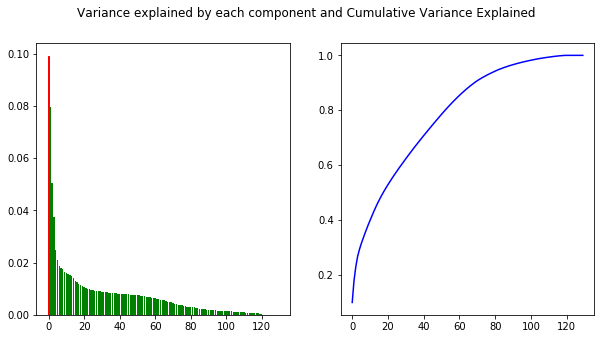

In [16]:
plotvariance(pca_all)

In [17]:
pca_50, X_pca_50 = do_pca(azdias_CIS,n_components = 50)

In [18]:
pca_40, X_pca_40 = do_pca(azdias_CIS,n_components = 40)

In [19]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_CI.columns)) # shape (40,130)
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [22]:
wpca_0 = get_weights(pca_40, 0)
print (wpca_0)

PLZ8_ANTG3               0.189630
HH_EINKOMMEN_SCORE       0.188654
CI_Wealth                0.185138
PLZ8_ANTG4               0.182271
ORTSGR_KLS9              0.161343
EWDICHTE                 0.159481
FINANZ_SPARER            0.159151
FINANZ_HAUSBAUER         0.145137
LP_STATUS_FEIN_2.0       0.138868
KBA05_ANTG4              0.130288
PLZ8_ANTG2               0.130082
SEMIO_PFLICHT            0.124044
KBA05_ANTG3              0.121935
SEMIO_REL                0.121601
PJ_DECADE                0.121269
ARBEIT                   0.118741
ANZ_HAUSHALTE_AKTIV      0.116421
CAMEO_DEUG_2015_9        0.116417
RELAT_AB                 0.111676
SEMIO_RAT                0.102681
SEMIO_TRADV              0.099853
ZABEOTYP_5               0.095230
CAMEO_DEUG_2015_8        0.091886
FINANZ_ANLEGER           0.090753
FINANZ_UNAUFFAELLIGER    0.090598
SEMIO_MAT                0.082698
SEMIO_FAM                0.080005
SEMIO_KULT               0.077590
GFK_URLAUBERTYP_12.0     0.069227
ZABEOTYP_4    

In [23]:
wpca_1 = get_weights(pca_40, 1)
print(wpca_1)

ALTERSKATEGORIE_GROB     0.218961
FINANZ_VORSORGER         0.207002
ZABEOTYP_3               0.200786
SEMIO_ERL                0.177183
SEMIO_LUST               0.156498
RETOURTYP_BK_S           0.154992
W_KEIT_KIND_HH           0.130084
FINANZ_HAUSBAUER         0.125424
PLZ8_ANTG3               0.109624
PLZ8_ANTG4               0.105242
EWDICHTE                 0.103986
CJT_GESAMTTYP_2.0        0.103622
ORTSGR_KLS9              0.102823
FINANZTYP_5              0.100881
CI_Wealth                0.097372
KBA05_ANTG4              0.080989
SEMIO_KRIT               0.080373
PLZ8_ANTG2               0.077431
FINANZTYP_2              0.077356
HH_EINKOMMEN_SCORE       0.077248
ARBEIT                   0.077002
SEMIO_KAEM               0.074860
RELAT_AB                 0.074377
ANZ_HAUSHALTE_AKTIV      0.072354
SHOPPER_TYP_3.0          0.070919
GFK_URLAUBERTYP_4.0      0.062881
KBA05_ANTG3              0.060296
LP_STATUS_FEIN_3.0       0.058444
FINANZTYP_6              0.057475
CAMEO_DEUG_201

In [24]:
wpca_2 = get_weights(pca_40, 2)
print (wpca_2)

SEMIO_VERT               0.330582
SEMIO_FAM                0.263902
SEMIO_SOZ                0.262385
SEMIO_KULT               0.253543
FINANZTYP_5              0.141595
FINANZ_MINIMALIST        0.136119
SEMIO_REL                0.108610
SEMIO_MAT                0.088029
RETOURTYP_BK_S           0.082220
GREEN_AVANTGARDE         0.074058
PJ_MOVEMENT              0.074058
W_KEIT_KIND_HH           0.067505
SHOPPER_TYP_1.0          0.060891
EWDICHTE                 0.060736
ORTSGR_KLS9              0.060611
FINANZ_VORSORGER         0.057257
LP_STATUS_GROB_5.0       0.052631
LP_STATUS_FEIN_10.0      0.052631
ZABEOTYP_6               0.052382
LP_STATUS_FEIN_3.0       0.048842
PLZ8_ANTG3               0.046882
PLZ8_ANTG4               0.045595
PLZ8_ANTG2               0.035830
RELAT_AB                 0.035327
ARBEIT                   0.032864
NATIONALITAET_KZ_2.0     0.030989
SEMIO_LUST               0.030707
GFK_URLAUBERTYP_4.0      0.029208
LP_FAMILIE_GROB_2.0      0.028935
LP_FAMILIE_FEI

### Discussion 2.3: Interpret Principal Components



From the first 3 PCAs I noticed the following : 

1- PLZ8_ANTG2 , PLZ8_ANTG3 , and PLZ8_ANTG4 are always correlated positively with each other and also positively correlated with CI_Wealth


2- the dummied features for example (LP_STATUS_FEIN) are not necesseraly positively or negatively correlated , while in some other they are ! , like for example the positive correlation between SEMIO_VERT dummied columns in PCA3 


3- Sometimes the very same feature have a a very positve value in some PCA while a small one in other PCAs 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [25]:
from sklearn.cluster import KMeans

In [26]:
def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [22]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
ks = list(range(1,25))
for i,k in enumerate(ks):
    score = k_mean_score(X_pca_40, k)
    scores.append(score)
    print(str(i) + ": " + str(score) )

KeyboardInterrupt: 

Text(0,0.5,'SSE')

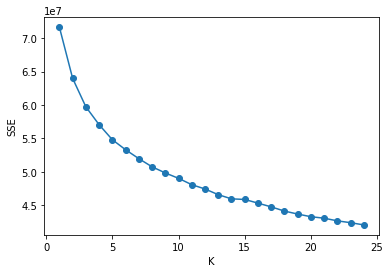

In [88]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(ks, scores, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')

In [27]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# from the plot above : i chose k = 15 

kmeans = KMeans(n_clusters = 15)
model_15 = kmeans.fit(X_pca_40)
azdias_pred = model_15.predict(X_pca_40)


In [28]:
kmeans.labels_

array([11,  3, 14, ...,  3, 13,  4], dtype=int32)

In [29]:
kmeans.cluster_centers_

array([[  3.68869814e+00,  -1.26706394e+00,  -2.15644484e+00,
          1.12145206e+00,   1.54790440e+00,   2.12619057e+00,
         -7.93500417e-01,   4.55382505e-01,  -1.16784837e+00,
         -1.36601538e-01,  -3.48396571e-01,  -4.74408952e-02,
          6.29758495e-01,   2.33977876e-01,  -4.29672877e-01,
         -3.25927417e-01,   9.74769827e-02,  -3.81684743e-01,
          3.10215468e-01,  -2.61902828e-01,   1.99601421e-01,
         -2.81528414e-01,   1.69702323e-01,   2.06791350e-01,
         -7.79722188e-02,  -1.23587190e-01,  -2.52096890e-01,
          1.57842913e-01,   9.24539677e-02,  -2.14560599e-01,
          2.12683350e-01,   7.25981843e-02,  -7.68602395e-03,
         -4.90999778e-02,  -8.73307486e-03,   4.81364640e-02,
         -1.04709462e-01,  -7.70123944e-02,   1.74762366e-02,
          2.92608553e-01],
       [  1.24284399e+00,   8.37688829e-01,   2.19452948e+00,
         -6.95226587e-01,  -4.93477870e-01,  -9.35739305e-02,
          2.41116808e-01,  -3.73885968e-01,

### Discussion 3.1: Apply Clustering to General Population

using PCA40, after running the function k_mean_score on range of k=1:25 , i have noticed that after k = 15 The SSE error stays almost the same or with a small difference. 

Which made me estimate k=15 , after that i initiated a k-mean model and fitted with cleaned_imputed_scaled dataset of azdias and got the results of where each row in the data set belong to which cluster in the 15 

kmeans.labels_ retuerns a list of thatt array([11,  3, 14, ...,  3, 13,  4], dtype=int32) , the first element in the list for instance says that this record belong to cluster 11


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [30]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [31]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)


• Step1.1 :Number of  missing values before is 2252274

• Step1.2 : Total number of missing values after conversion is 3112918

• Step2 : azdias number of rows after Nans treatment 191652 , while number of columns 32

• Step3.1: Number of rows missing more than 20% of the data is 93 , while number of rows missing less than 20% 191559

• Step3.2 number of rows after column cleaning 191559 , number of columns 32

• Step5 Number of rows after dealing with Multi and Binary Categorical data 191559 , while number of columns 65

• Step6 Number of rows after dealing with Mixed Features is 191559 , number of columns 65


In [32]:
customers_clean.head()

,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,ONLINE_AFFINITAET
0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,4.0,1,5,1,5,1,2,2,1,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,1.0,3.0
2,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,4.0,2,5,1,5,1,4,4,1,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,1.0
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,4.0,1,5,1,5,2,1,2,0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,4.0,2.0
4,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,1,3,1,4,4,5,2,0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,6.0,5.0
5,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,3.0,1,5,1,5,1,2,3,1,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,1.0,3.0


In [33]:
# Impute NANS and SCALE the data - same way as before 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

imputer = Imputer(strategy='most_frequent')
scaler = StandardScaler() 

In [34]:
customers_CI = pd.DataFrame(imputer.fit_transform(customers_clean) , columns=customers_clean.columns , index = customers_clean.index)

In [35]:
customers_CIS = pd.DataFrame(scaler.fit_transform(customers_CI),columns=customers_clean.columns , index = customers_clean.index)

In [30]:
#pca_all2, X_pca_all2 = do_pca(customers_CIS)

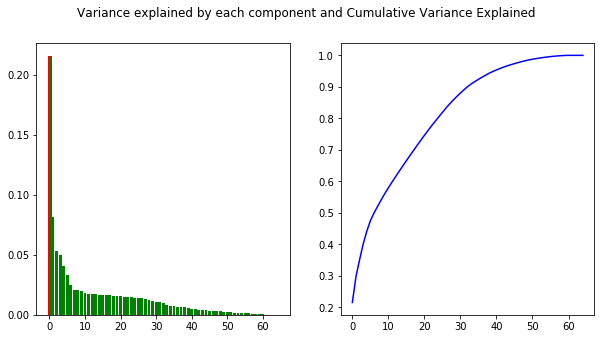

In [31]:
#plotvariance(pca_all2)

In [32]:
# from the sketch i chose 30 PCAs

In [35]:
#pca_all2_30, X_pca_all2_30 = do_pca(customers_CIS,30)

In [36]:
#scores = []
#ks = list(range(1,20))
#for i,k in enumerate(ks):
#    score = k_mean_score(X_pca_all2_30, k)
#    scores.append(score)
#    print(str(i) + ": " + str(score) )
    

0: 10827908.8941
1: 8449421.886
2: 7599035.63792
3: 7171660.20785
4: 6828500.69913
5: 6589400.46137
6: 6280781.6836
7: 6073290.85414
8: 5892372.45683
9: 5754132.34946
10: 5603899.50685
11: 5494671.98797
12: 5367929.28408
13: 5175445.26047
14: 5046453.6518
15: 4971480.57226
16: 4890333.28542
17: 4725753.53601
18: 4694296.13043


Text(0,0.5,'SSE')

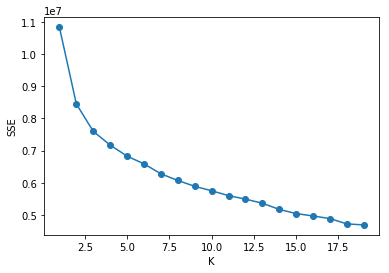

In [37]:
#plt.plot(ks, scores, linestyle='-', marker='o')
#plt.xlabel('K')
#plt.ylabel('SSE')

In [ ]:
# from tthe sketch above i chose k=12
# pca_40, X_pca_40

In [36]:
customers_pca = pca_40.fit_transform(customers_CIS)

In [37]:
customers_predict = model_15.predict(customers_pca)

In [38]:
set(customers_predict.tolist())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Udacity Customers')

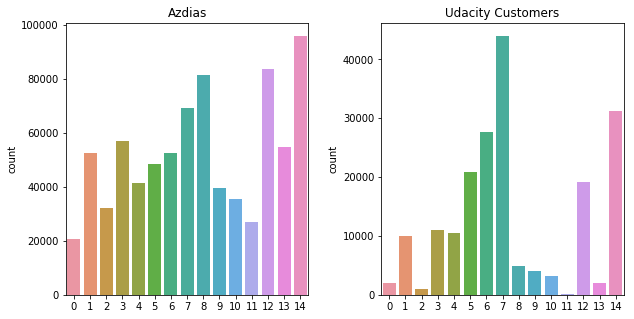

In [57]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(azdias_pred, ax=axs[0])
axs[0].set_title('Azdias')

sns.countplot(customers_predict, ax=axs[1])
axs[1].set_title('Udacity Customers')







In [56]:
len(customers_predict)

191559

In [58]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# I have noticed that there are no clusters that are over presented in Udacity customers 
# compared to Azdias , However, cluster 5 seems to be close! 
peaple_over_presented = scaler.inverse_transform(pca_40.inverse_transform(model_15.cluster_centers_[5]))
peaple_over_presented_c = pd.Series(data = peaple_over_presented, index = customers_CIS.columns)
peaple_over_presented_c


CJT_GESAMTTYP_2.0        0.447251
CJT_GESAMTTYP_3.0       -0.052346
CJT_GESAMTTYP_4.0        0.002011
CJT_GESAMTTYP_5.0        0.272393
CJT_GESAMTTYP_6.0        0.091062
FINANZTYP_2              0.554787
FINANZTYP_3             -0.057623
FINANZTYP_4              0.032898
FINANZTYP_5             -0.073568
FINANZTYP_6              0.500562
GFK_URLAUBERTYP_2.0      0.032802
GFK_URLAUBERTYP_3.0      0.171154
GFK_URLAUBERTYP_4.0      0.061305
GFK_URLAUBERTYP_5.0      0.153321
GFK_URLAUBERTYP_6.0      0.061590
GFK_URLAUBERTYP_7.0      0.084597
GFK_URLAUBERTYP_8.0     -0.062002
GFK_URLAUBERTYP_9.0     -0.009880
GFK_URLAUBERTYP_10.0     0.272253
GFK_URLAUBERTYP_11.0     0.015427
GFK_URLAUBERTYP_12.0     0.137509
LP_STATUS_FEIN_2.0       0.016772
LP_STATUS_FEIN_3.0       0.149095
LP_STATUS_FEIN_4.0       0.143713
LP_STATUS_FEIN_5.0       0.065781
LP_STATUS_FEIN_6.0       0.043639
LP_STATUS_FEIN_7.0       0.037897
LP_STATUS_FEIN_8.0       0.018395
LP_STATUS_FEIN_9.0       0.550328
LP_STATUS_FEIN

In [59]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# almost all of them! however i chose here cluster 13 
peaple_under_presented = scaler.inverse_transform(pca_40.inverse_transform(model_15.cluster_centers_[13]))
peaple_under_presented_c = pd.Series(data = peaple_under_presented, index = customers_CIS.columns)
peaple_under_presented_c


CJT_GESAMTTYP_2.0        0.180934
CJT_GESAMTTYP_3.0       -0.081115
CJT_GESAMTTYP_4.0        0.122010
CJT_GESAMTTYP_5.0        0.139000
CJT_GESAMTTYP_6.0        0.587618
FINANZTYP_2              0.268172
FINANZTYP_3              0.042890
FINANZTYP_4              0.662464
FINANZTYP_5             -0.350468
FINANZTYP_6              0.292685
GFK_URLAUBERTYP_2.0     -0.015982
GFK_URLAUBERTYP_3.0      0.083079
GFK_URLAUBERTYP_4.0     -0.060214
GFK_URLAUBERTYP_5.0      0.536466
GFK_URLAUBERTYP_6.0      0.093712
GFK_URLAUBERTYP_7.0      0.017412
GFK_URLAUBERTYP_8.0     -0.061980
GFK_URLAUBERTYP_9.0      0.130473
GFK_URLAUBERTYP_10.0     0.093298
GFK_URLAUBERTYP_11.0     0.075444
GFK_URLAUBERTYP_12.0     0.071981
LP_STATUS_FEIN_2.0       0.031418
LP_STATUS_FEIN_3.0       0.127522
LP_STATUS_FEIN_4.0       0.118152
LP_STATUS_FEIN_5.0       0.569772
LP_STATUS_FEIN_6.0       0.030735
LP_STATUS_FEIN_7.0      -0.011250
LP_STATUS_FEIN_8.0      -0.017433
LP_STATUS_FEIN_9.0       0.457328
LP_STATUS_FEIN

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

    * I have noticed that there are no clusters that are over presented in Udacity customers compared to Azdias , However, cluster 5 seems to be close!
    * almost all of them were underpresented in customer data! however i chose here cluster 13
    
    here are Some characteristics of the segment of the population that are relatively unpopular with the company:
    
    1-CJT_GESAMTTYP : Customer-Journey-Typology: preferred information and buying channels for consumer whether Advertising- and Consumptiontraditionalist or the other categories 3,4,5,6
    
    2- FINANZTYP_2 : Most descriptive financial type for individual
    wheather -  2: money-saver (SPARER) 3: home ownership (HAUSBAUER)4: be prepared (VORSORGER)5: investor (ANLEGER  6: inconspicuous (UNAUFFAELLIGER)
    


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.